In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/27-class-sign-language-dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/27-class-sign-language-dataset/Y.npy
/kaggle/input/27-class-sign-language-dataset/X.npy


In [2]:
# Load features (images) and labels
X = np.load('/kaggle/input/27-class-sign-language-dataset/X.npy')
y = np.load('/kaggle/input/27-class-sign-language-dataset/Y.npy')

In [3]:
import numpy as np
import keras
import matplotlib.pyplot as plt
from keras.models import Model
from tensorflow.keras import layers, models
from keras.layers import Input, Conv2D, MaxPooling2D, Activation, concatenate, Dropout, GlobalAveragePooling2D,Dense
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras import backend as K
from keras.applications.imagenet_utils import preprocess_input
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

2025-05-03 19:06:34.288186: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746299194.492295      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746299194.551115      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
!pip install tensorflow==2.16.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 66.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 90.6 MB/s eta 0:00:00:00:01
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.18.0
    Uninstalling tensorflow-2.18.0:
      Successfully uninstalled tensorflow-2.18.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.11.0 requires tensorflow==2.18.0,

In [5]:
def resize_images(images, target_size=(128,128)):
    resized_images = []
    for img in images:
        resized = cv2.resize(img, target_size)
        resized_images.append(resized)
    return np.array(resized_images)

X_resized = resize_images(X)

In [6]:
images = X.astype('float32')
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(y.reshape(-1))
y_categorical = to_categorical(labels)

In [7]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,  
    fill_mode='nearest'
)
X_train, X_val, y_train, y_val = train_test_split(
    X_resized, y_categorical, test_size=0.2, random_state=42
)

train_generator = train_datagen.flow(
    x=X_train,
    y=y_train,
    batch_size=32,
    shuffle=True
)

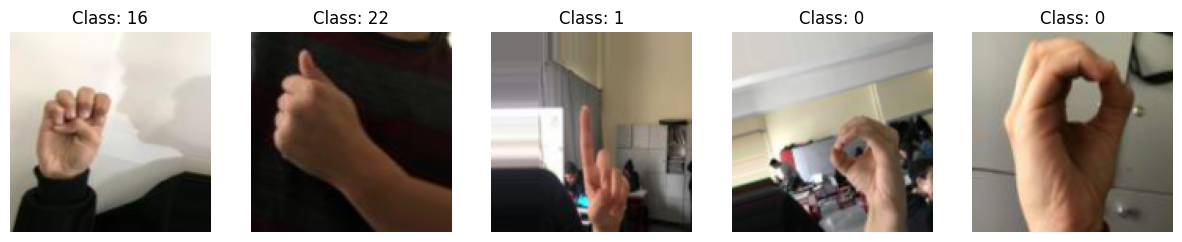

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def plot_samples(images, labels, num_samples=5, augmentation_type="Original"):
    plt.figure(figsize=(15, 3))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        
        # For grayscale images (single channel)
        if images[i].shape[-1] == 1:
            plt.imshow(images[ai].squeeze(), cmap='gray')
        else:
            plt.imshow(images[i])
            
        plt.title(f"{augmentation_type}\nClass: {np.argmax(labels[i])}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

import matplotlib.pyplot as plt

# Generate a batch of augmented images
aug_images, aug_labels = next(train_generator)  # Correct syntax

# Plot samples
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    
    # For grayscale images (1 channel)
    if aug_images[i].shape[-1] == 1:
        plt.imshow(aug_images[i].squeeze(), cmap='gray')
    else:
        plt.imshow(aug_images[i])
    
    plt.title(f"Class: {np.argmax(aug_labels[i])}")
    plt.axis('off')
plt.show()

In [9]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

for layer in base_model.layers:
    layer.trainable = False




x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(27, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


I0000 00:00:1746299283.698512      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746299283.699506      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [10]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32
)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1746299319.030961     105 service.cc:148] XLA service 0x7a07600d4260 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746299319.031027     105 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1746299319.031034     105 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1746299323.745384     105 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/570 ━━━━━━━━━━━━━━━━━━━━ 53s 95ms/step - accuracy: 0.0312 - loss: 4.7127   

I0000 00:00:1746299330.599648     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


570/570 ━━━━━━━━━━━━━━━━━━━━ 142s 179ms/step - accuracy: 0.0503 - loss: 4.6240 - val_accuracy: 0.1546 - val_loss: 3.0134
Epoch 2/10
570/570 ━━━━━━━━━━━━━━━━━━━━ 80s 139ms/step - accuracy: 0.0852 - loss: 3.8474 - val_accuracy: 0.2210 - val_loss: 2.6891
Epoch 3/10
570/570 ━━━━━━━━━━━━━━━━━━━━ 80s 139ms/step - accuracy: 0.1230 - loss: 3.5102 - val_accuracy: 0.2635 - val_loss: 2.5241
Epoch 4/10
570/570 ━━━━━━━━━━━━━━━━━━━━ 80s 139ms/step - accuracy: 0.1441 - loss: 3.2795 - val_accuracy: 0.2931 - val_loss: 2.4097
Epoch 5/10
570/570 ━━━━━━━━━━━━━━━━━━━━ 80s 139ms/step - accuracy: 0.1668 - loss: 3.0913 - val_accuracy: 0.3188 - val_loss: 2.3321
Epoch 6/10
570/570 ━━━━━━━━━━━━━━━━━━━━ 80s 138ms/step - accuracy: 0.1859 - loss: 2.9893 - val_accuracy: 0.3374 - val_loss: 2.2660
Epoch 7/10
570/570 ━━━━━━━━━━━━━━━━━━━━ 81s 141ms/step - accuracy: 0.2005 - loss: 2.8907 - val_accuracy: 0.3477 - val_loss: 2.2132
Epoch 8/10
570/570 ━━━━━━━━━━━━━━━━━━━━ 80s 139ms/step - accuracy: 0.2109 - loss: 2.8232 - va

In [11]:
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=1)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")

143/143 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.3971 - loss: 2.0988
Validation Accuracy: 39.60%
Validation Loss: 2.0901


In [13]:
for layer in base_model.layers:
    if 'block8' in layer.name or 'conv_7b' in layer.name:
        layer.trainable = True

In [15]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32
)


Epoch 1/10
570/570 ━━━━━━━━━━━━━━━━━━━━ 143s 175ms/step - accuracy: 0.2777 - loss: 2.6037 - val_accuracy: 0.4543 - val_loss: 1.7946
Epoch 2/10
570/570 ━━━━━━━━━━━━━━━━━━━━ 81s 141ms/step - accuracy: 0.3792 - loss: 2.0385 - val_accuracy: 0.5586 - val_loss: 1.4143
Epoch 3/10
570/570 ━━━━━━━━━━━━━━━━━━━━ 81s 141ms/step - accuracy: 0.4579 - loss: 1.7009 - val_accuracy: 0.6205 - val_loss: 1.1633
Epoch 4/10
570/570 ━━━━━━━━━━━━━━━━━━━━ 80s 139ms/step - accuracy: 0.5335 - loss: 1.4559 - val_accuracy: 0.6672 - val_loss: 0.9997
Epoch 5/10
570/570 ━━━━━━━━━━━━━━━━━━━━ 81s 140ms/step - accuracy: 0.5743 - loss: 1.3099 - val_accuracy: 0.7027 - val_loss: 0.8950
Epoch 6/10
570/570 ━━━━━━━━━━━━━━━━━━━━ 81s 141ms/step - accuracy: 0.6066 - loss: 1.1980 - val_accuracy: 0.7202 - val_loss: 0.8209
Epoch 7/10
570/570 ━━━━━━━━━━━━━━━━━━━━ 80s 139ms/step - accuracy: 0.6296 - loss: 1.1062 - val_accuracy: 0.7351 - val_loss: 0.7653
Epoch 8/10
570/570 ━━━━━━━━━━━━━━━━━━━━ 80s 140ms/step - accuracy: 0.6520 - loss: 

In [16]:
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=1)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")

143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.7749 - loss: 0.6509
Validation Accuracy: 77.77%
Validation Loss: 0.6441


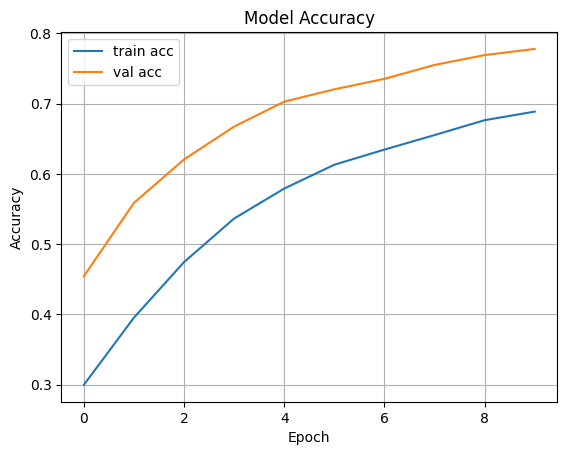

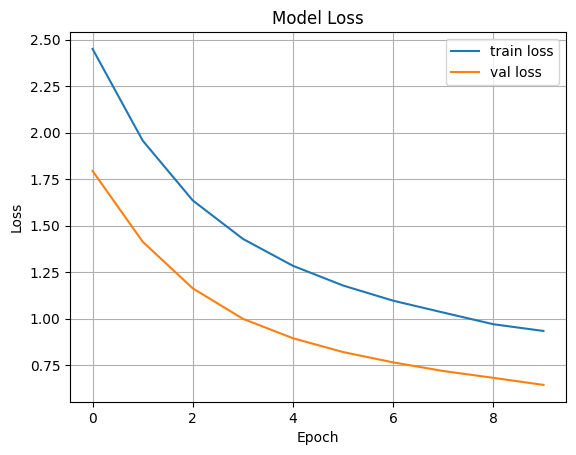

In [17]:
# Accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

def make_gradcam_heatmap(img_array, model, last_conv_layer_name='conv_7b_ac', pred_index=None):
    """Generate Grad-CAM heatmap for an input image."""
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_output = predictions[:, pred_index]

    grads = tape.gradient(class_output, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap) + 1e-8
    return heatmap.numpy()

def display_gradcam(img, heatmap, alpha=0.4):
    """Display the Grad-CAM heatmap superimposed on the image."""
    heatmap_uint8 = np.uint8(255 * heatmap)
    jet = plt.colormaps.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap_uint8]
    jet_heatmap = cv2.resize(jet_heatmap, (img.shape[1], img.shape[0]))

    if img.max() <= 1.0:
        img = img * 255
        img = img.astype(np.uint8)

    superimposed_img = (1 - alpha) * img / 255.0 + alpha * jet_heatmap
    superimposed_img = np.clip(superimposed_img * 255, 0, 255).astype(np.uint8)
    return superimposed_img

def visualize_misclassifications(model, X_val, y_true, class_names=None, 
                               last_conv_layer='conv_7b_ac', num_examples=3):
    """
    Visualize misclassifications using Grad-CAM without label encoder.
    
    Args:
        model: Your trained InceptionResNetV2 model
        X_val: Validation images (numpy array)
        y_true: True labels (either as integers or one-hot encoded)
        class_names: List of class names (optional)
        last_conv_layer: Name of last conv layer to use for Grad-CAM
        num_examples: Number of misclassified examples to show
    """
    # Convert y_true to class indices if it's one-hot encoded
    if y_true.ndim > 1:
        y_true_classes = np.argmax(y_true, axis=1)
    else:
        y_true_classes = y_true
    
    # Get model predictions
    y_pred = model.predict(X_val, batch_size=32)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Find misclassified examples
    misclassified_indices = np.where(y_pred_classes != y_true_classes)[0]
    
    # If class_names not provided, use indices
    if class_names is None:
        class_names = [str(i) for i in range(y_pred.shape[1])]
    
    # Visualize first few misclassifications
    for i in misclassified_indices[:num_examples]:
        img = X_val[i]
        img_array = np.expand_dims(img, axis=0)
        
        # Generate heatmap
        heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name=last_conv_layer)
        
        # Prepare image for display
        img_for_display = (img * 255).astype(np.uint8) if img.max() <= 1.0 else img
        
        # Get labels
        pred_label = class_names[y_pred_classes[i]]
        true_label = class_names[y_true_classes[i]]
        
        # Create figure
        plt.figure(figsize=(15, 5))
        
        # Original image
        plt.subplot(1, 3, 1)
        plt.imshow(img_for_display)
        plt.title(f"True: {true_label}")
        plt.axis('off')
        
        # Heatmap
        plt.subplot(1, 3, 2)
        plt.imshow(heatmap, cmap='viridis')
        plt.title("Activation Heatmap")
        plt.axis('off')
        
        # Superimposed
        plt.subplot(1, 3, 3)
        superimposed_img = display_gradcam(img_for_display, heatmap)
        plt.imshow(superimposed_img)
        plt.title(f"Pred: {pred_label}")
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()

143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step


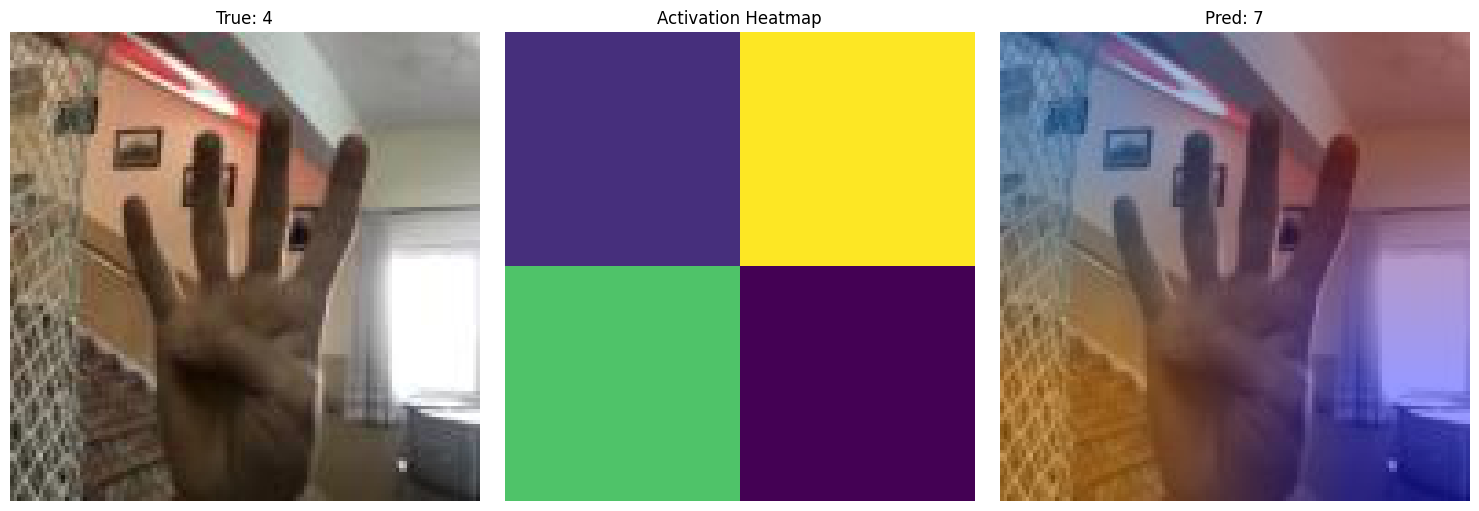

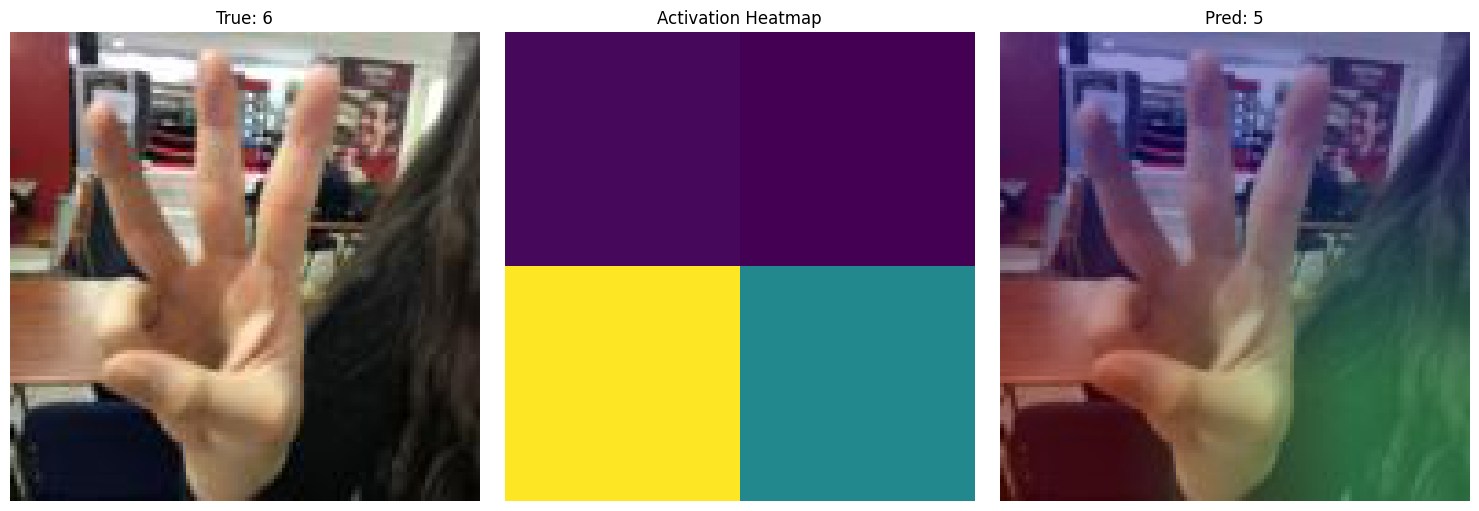

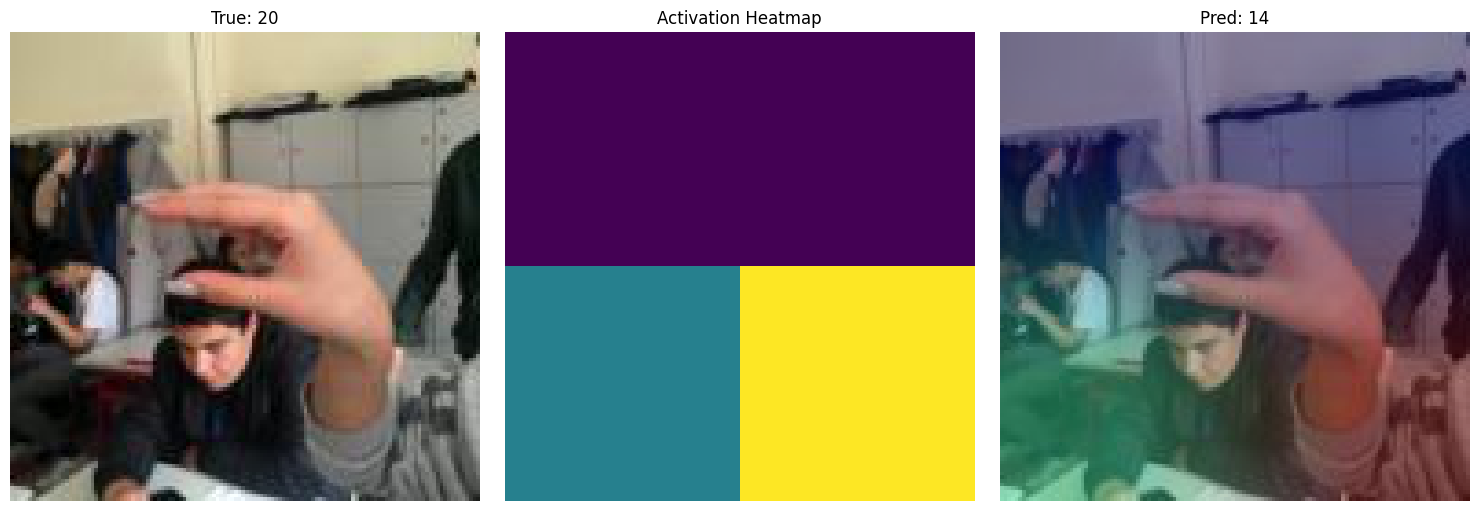

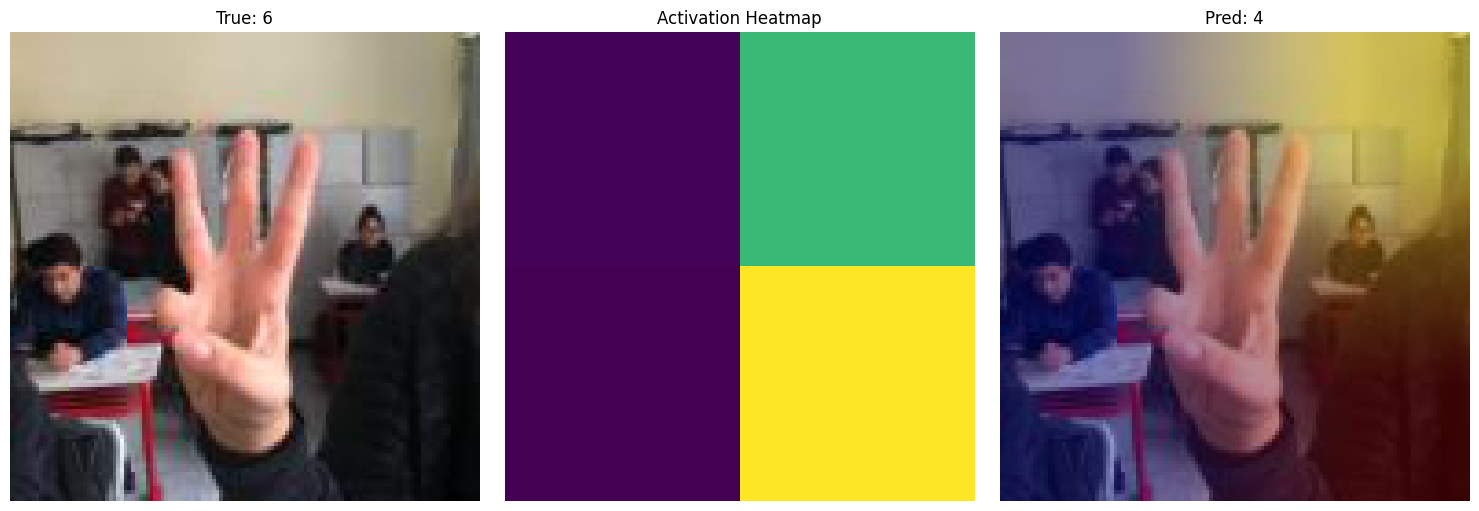

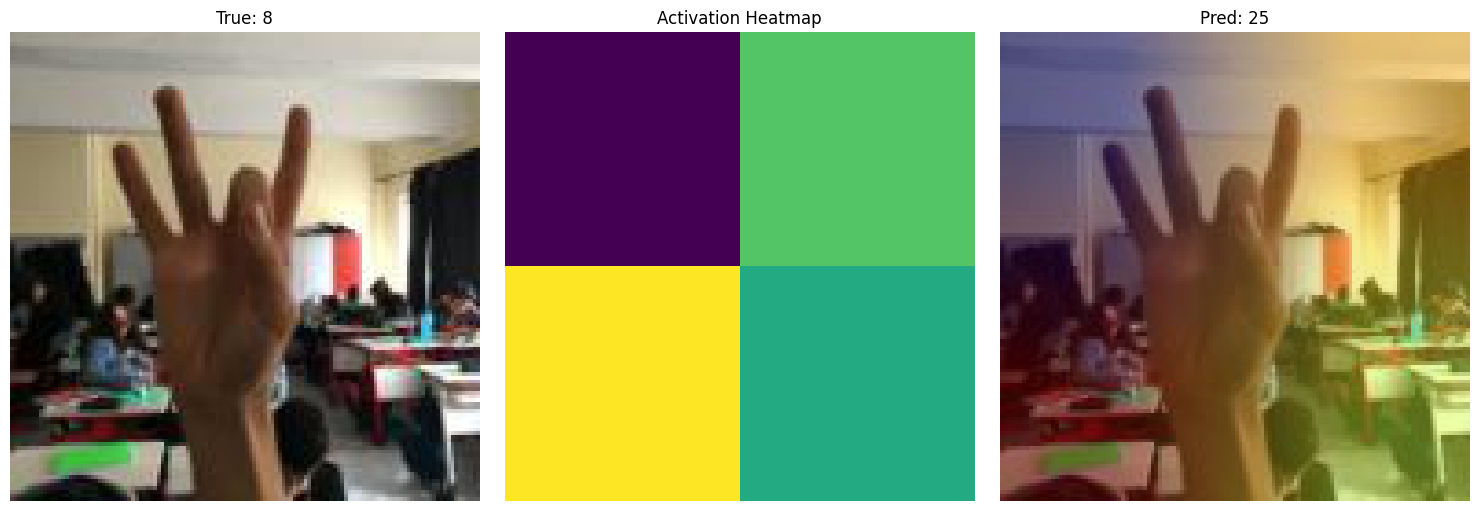

In [26]:
visualize_misclassifications(
    model=model,
    X_val=X_val,
    y_true=y_val,
    last_conv_layer='conv_7b_ac',
    num_examples=5
)

143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step


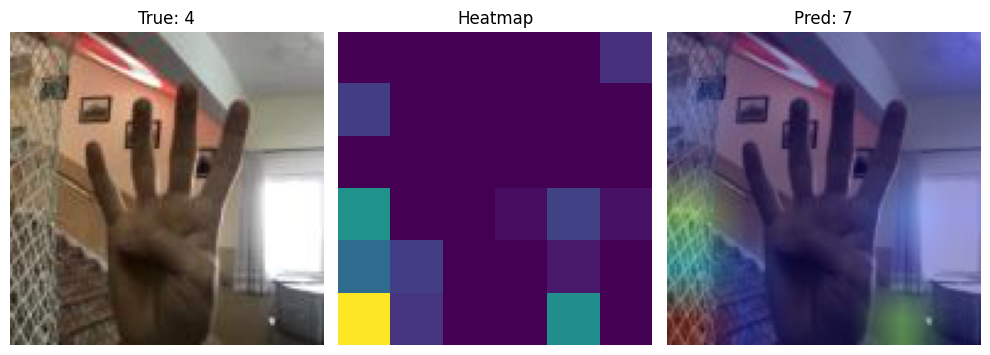

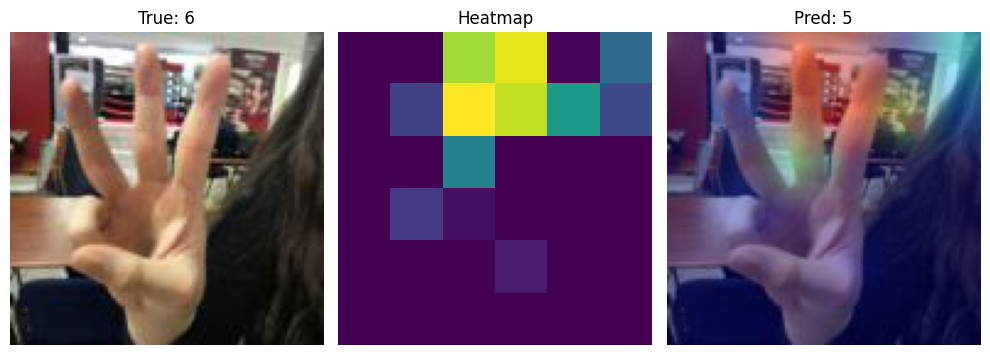

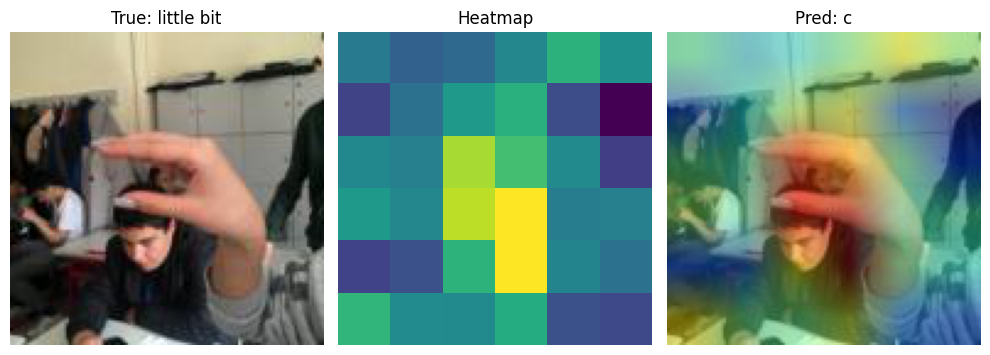

In [35]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

# Your existing InceptionResNetV2-based model
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_output = predictions[:, pred_index]

    grads = tape.gradient(class_output, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap) + 1e-8
    return heatmap.numpy()

def display_gradcam(img, heatmap, alpha=0.4):
    heatmap_uint8 = np.uint8(255 * heatmap)
    jet = plt.colormaps.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap_uint8]
    jet_heatmap = cv2.resize(jet_heatmap, (img.shape[1], img.shape[0]))

    if img.max() <= 1.0:
        img = img * 255
    img = img.astype(np.uint8)

    superimposed_img = (1 - alpha) * img / 255.0 + alpha * jet_heatmap
    superimposed_img = np.clip(superimposed_img * 255, 0, 255).astype(np.uint8)

    plt.imshow(superimposed_img)
    plt.axis('off')
    return superimposed_img

# Predict and display misclassified examples
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

misclassified_indices = np.where(y_pred_classes != y_true_classes)[0]

for i in misclassified_indices[:3]:
    img = X_val[i]
    img_array = np.expand_dims(img, axis=0)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name='conv2d_149')

    img_for_display = img
    if img_for_display.max() <= 1.0:
        img_for_display = (img_for_display * 255).astype(np.uint8)

    pred_label = label_encoder.inverse_transform([y_pred_classes[i]])[0]
    true_label = label_encoder.inverse_transform([y_true_classes[i]])[0]

    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 3, 1)
    plt.imshow(img_for_display)
    plt.title(f"True: {true_label}")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap, cmap='viridis')
    plt.title("Heatmap")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    display_gradcam(img_for_display, heatmap)
    plt.title(f"Pred: {pred_label}")

    plt.tight_layout()
    plt.show()


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━

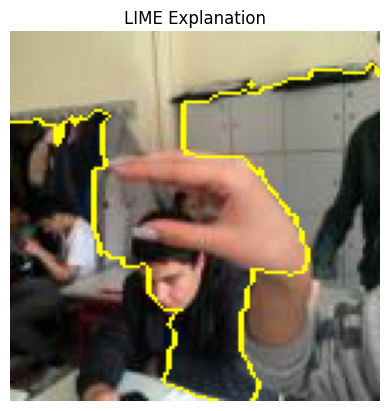

In [27]:

from lime import lime_image
from skimage.segmentation import mark_boundaries

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    image=img.astype('double'),
    classifier_fn=lambda x: model.predict(x),
    top_labels=1,
    hide_color=0,
    num_samples=1000
)

temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=True,
    hide_rest=False
)

plt.imshow(mark_boundaries(temp, mask))
plt.title("LIME Explanation")
plt.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━

PartitionExplainer explainer: 2it [00:19, 19.45s/it]               


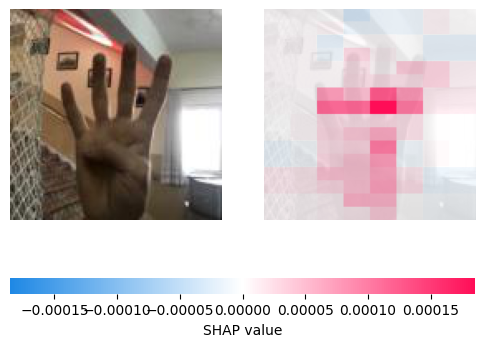

In [28]:

import shap
from shap.maskers import Image
import numpy as np


test_images = X_val[misclassified_indices[:1]]  

preds = model.predict(test_images)
pred_class = np.argmax(preds[0])  
masker = Image("blur(128,128)", test_images[0].shape)

explainer = shap.Explainer(
    lambda x: model.predict(x)[:, pred_class],  # target one class
    masker
)
shap_values = explainer(test_images)

shap.plots.image(shap_values)


In [29]:

import numpy as np
import matplotlib.pyplot as plt

def feature_ablation_heatmap(image, model, class_idx=None, patch_size=20):
    img = image.copy()
    h, w, c = img.shape
    n_patches_y = h // patch_size
    n_patches_x = w // patch_size
    heatmap = np.zeros((n_patches_y, n_patches_x))
    orig_pred = model.predict(img[None])[0]
    
    if class_idx is None:
        class_idx = np.argmax(orig_pred)
    orig_conf = orig_pred[class_idx]

    for i in range(n_patches_y):
        for j in range(n_patches_x):
            occluded = img.copy()
            y_start = i * patch_size
            x_start = j * patch_size

            
            occluded[y_start:y_start+patch_size, x_start:x_start+patch_size, :] = 0.5
            occl_pred = model.predict(occluded[None])[0][class_idx]
            delta = orig_conf - occl_pred
            heatmap[i, j] = delta

    
    heatmap_resized = np.kron(heatmap, np.ones((patch_size, patch_size)))
    heatmap_resized = heatmap_resized[:h, :w]

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(img)
    plt.imshow(heatmap_resized, cmap='hot', alpha=0.5)
    plt.axis('off')
    plt.title("Feature Ablation Map")
    plt.colorbar(label="Drop in confidence")
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━

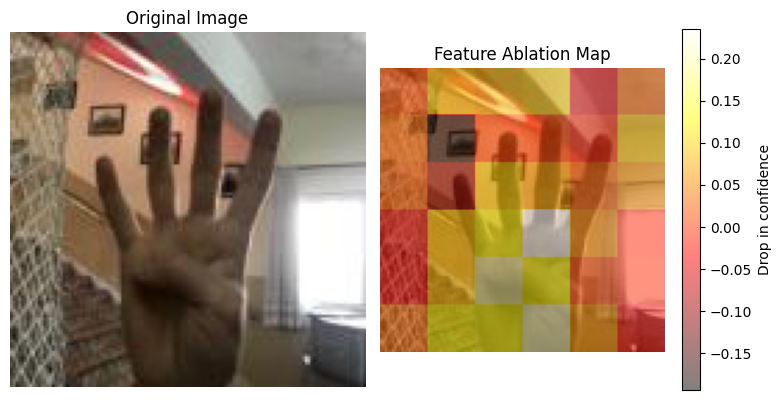

In [30]:
feature_ablation_heatmap(test_images[0], model)
